In [ ]:
import os
from tqdm import tqdm
from PIL import Image
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, CSVLogger,ModelCheckpoint
from sklearn.model_selection import train_test_split

from model import get_model
from metrics import *
from utils import *

In [ ]:
images_filenames_train = []
labels_filenames_train = []

path_name = 'data/labeled_images'
path = os.listdir(path=path_name)

for p in path:
    path_images = os.listdir(path=path_name + '/' + p + '/Images/')
    path_labels = os.listdir(path=path_name + '/' + p + '/Pigment/')
    for n in path_images:
        images_filenames_train.append(path_name + '/' + p + '/Images/' + n)
    for n in path_labels:
        labels_filenames_train.append(path_name + '/' + p + '/Pigment/' + n)

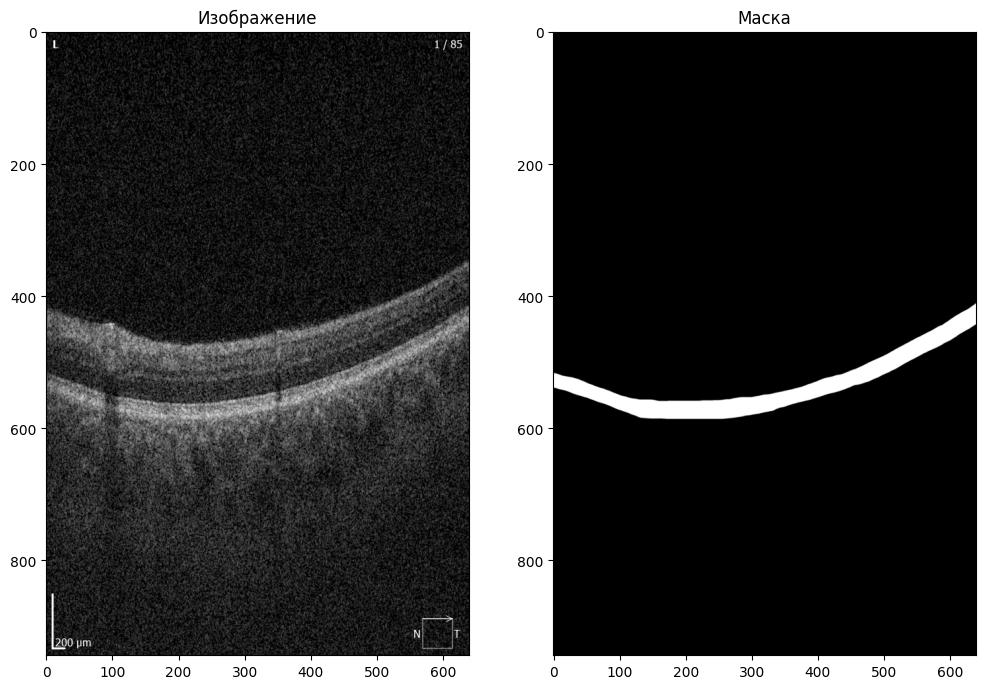

In [ ]:
plot_images_and_labels(images_filenames_train[0], labels_filenames_train[0])

In [ ]:
output_size = (256, 256)
resized_images, resized_labels = [], []

for im, l in tqdm(zip(images_filenames_train, labels_filenames_train)):
    image = Image.open(im)
    image = image.crop((0, 200, 640, 840))
    image = image.resize(output_size)
    label = Image.open(l)
    label = label.crop((0, 200, 640, 840))
    label = label.resize(output_size)
    resized_images.append(image)
    resized_labels.append(label)

510it [04:19,  1.96it/s]


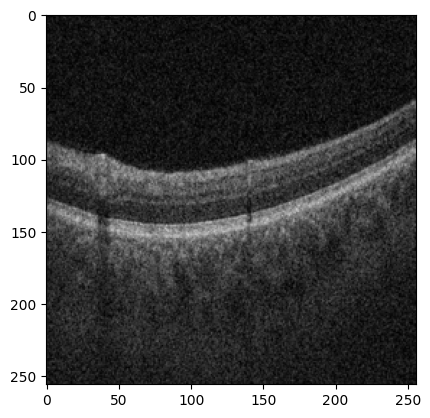

In [ ]:
plt.imshow(resized_images[0], cmap='gray')

In [ ]:
for i, (im, l) in enumerate(zip(resized_images, resized_labels)):
    im = im.save('ResizedImages/' + str(i) + '.png')
    l = l.save('ResizedPigments/' + str(i) + '.png')

In [ ]:
images_filenames_train = ['ResizedImages/' + p for p in os.listdir(path='ResizedImages')]
labels_filenames_train = ['ResizedPigments/' + p for p in os.listdir(path='ResizedPigments')]

In [ ]:
images = [io.imread(im, as_gray=True) for im in images_filenames_train]
labels = [io.imread(l, as_gray=True) for l in labels_filenames_train]

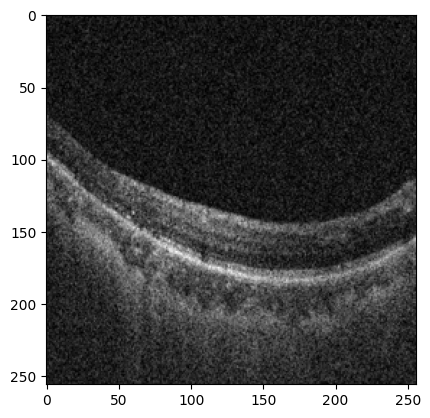

In [ ]:
plt.imshow(images[0], cmap = 'gray')

In [ ]:
labels = np.asarray(labels)
train_labels = np.zeros((labels.shape[0],256,256,2))

for i in range(len(labels)):
    for j in range(256):
        for k in range(256):
            if labels[i][j][k] == 0:
              train_labels[i][j][k][0] = 1
            else:
              train_labels[i][j][k][1] = 1

In [ ]:
images=np.array(images)
images = images.reshape(images.shape[0],256,256,1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, train_labels, test_size = 0.1, random_state=42)

In [ ]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate = 0.01),loss=customized_loss,metrics=['accuracy',dice_coefficient],sample_weight_mode='temporal')

In [ ]:
lr_reducer = ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6)
csv_logger = CSVLogger('Model/ModelSettings/PigmentLogger.csv')
model_checkpoint = ModelCheckpoint("Model/ModelSettings/Pigment-weights.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)

In [ ]:
history = model.fit(X_train,y_train,batch_size=20,epochs=100,validation_data=(X_test,y_test),callbacks=[lr_reducer, csv_logger,model_checkpoint])

Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: -0.1114 - accuracy: 0.9304 - dice_coefficient: 0.9050
Epoch 1: val_loss improved from inf to 43.43389, saving model to Relaynet.hdf5
23/23 [==============================] - 34s 724ms/step - loss: -0.1114 - accuracy: 0.9304 - dice_coefficient: 0.9050 - val_loss: 43.4339 - val_accuracy: 0.0453 - val_dice_coefficient: 0.0456 - lr: 0.0100
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: -0.2486 - accuracy: 0.9673 - dice_coefficient: 0.9550
Epoch 2: val_loss improved from 43.43389 to 8.09919, saving model to Relaynet.hdf5
23/23 [==============================] - 7s 298ms/step - loss: -0.2486 - accuracy: 0.9673 - dice_coefficient: 0.9550 - val_loss: 8.0992 - val_accuracy: 0.0703 - val_dice_coefficient: 0.0813 - lr: 0.0100
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: -0.2742 - accuracy: 0.9695 - dice_coefficient: 0.9589
Epoch 3: val_loss improved from 8.09919 to 0.21342, saving mo

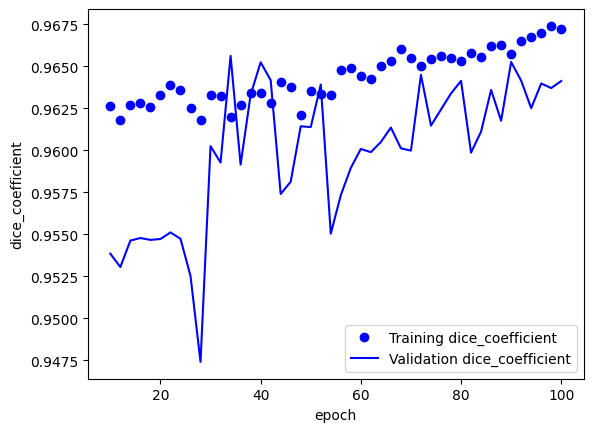

In [ ]:
epochs = range(10, 100 + 1,2)
plt.plot(epochs, history.history['dice_coefficient'][9::2], 'bo', label='Training dice_coefficient')
plt.plot(epochs, history.history['val_dice_coefficient'][9::2], 'b', label='Validation dice_coefficient')
plt.legend()
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.load_weights('Model/ModelSettings/Pigment-weights.hdf5')

In [ ]:
model.save('Model/ModelSettings/Pigment-model.h5')